In [126]:
from glob import glob
from os.path import join
import os
import numpy as np
import itertools
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, WhiteKernel, Matern
import matplotlib.pyplot as plt
import pandas as pd

# Data choice

In [127]:
experiment = 'december'

In [128]:
fruit = 'orange'

In [129]:
cut_quality = 'good' # good / shallow / deep

In [130]:
train_percentage = 0.7

# Segmented data reading

In [131]:
data_folder = join('..', 'data', 'segmented_data', experiment, fruit, cut_quality)

In [132]:
data_files = os.listdir(data_folder)
print(data_files)

['orange_good_1.csv', 'orange_good_14.csv', 'orange_good_4.csv', 'orange_good_11.csv', 'orange_good_12.csv', 'orange_good_3.csv', 'orange_good_5.csv', 'orange_good_6.csv', 'orange_good_9.csv', 'orange_good_7.csv', 'orange_good_13.csv', 'orange_good_10.csv', 'orange_good_2.csv', 'orange_good_15.csv', 'orange_good_8.csv']


In [148]:
timeseries = []

for f in data_files:
    data = pd.read_csv(join(data_folder, f), index_col=0)
    data['label'] = '-'.join([fruit, cut_quality])
    timeseries.append(data)

# Split preparation

In [209]:
x_header = 'displacement'
y_header = ['force_x', 'force_y', 'force_z', 'label']

X_train, X_test, y_train, y_test = train_test_split([t[x_header] for t in timeseries], [t[y_header] for t in timeseries], test_size=1-train_percentage, random_state=42)

X_train_vecto
for i, X in enumerate(X_train):
    X_train_vector.extend(X.values)
Y_train_vector = []
for i, X in enumerate(X_train):
    X_train_vector.extend(X.values)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00017163509662950041, 0.00017985763871012416, 0.00018943485526294105, 0.000205865524798076, 0.0002495578375042429, 0.00027299571191309005, 0.0002790842134524625, 0.00028653911283501714, 0.0003201233667084062, 0.00033484779017212997, 0.00034262056522495166, 0.00035387327440695424, 0.00037255918071248573, 0.00042988880074602386, 0.000448176786917332, 0.0004900030331892125, 0.0005051410929306611, 0.0005243916764566668, 0.0006333883914997147, 0.0006383841391532486, 0.0006415240730894704, 0.0006559088484136644, 0.0007019069559160007, 0.0007351917807154916, 0.000767831056939318, 0.0008518597397219699, 0.0008669021198841005, 0.0008962438173586574, 0.0009025402032877156, 0.0009098079620840877, 0.0009144155512261996, 0.0010661816445256078, 0.0010816973162626736, 0.0010924136679219061, 0.0011335273446896185, 0.0011678166454745075, 0.0011752176443693186, 0.0011770429265791403, 0.0011824514320644625, 0.0011908488511054238, 0.0012121793317834285,

# ML pipeline

In [74]:
gpr = GaussianProcessRegressor()

In [75]:
rbf_kernel = RBF()

In [76]:
dot_kernel = DotProduct() + WhiteKernel()

In [77]:
pipe = Pipeline(steps=[('gpr', gpr)])

## Parameter tuning

### list algorithms parameters

In [78]:
print(gpr.get_params().keys())

dict_keys(['alpha', 'copy_X_train', 'kernel', 'n_restarts_optimizer', 'normalize_y', 'optimizer', 'random_state'])


### list kernel parameters

In [79]:
print(rbf_kernel.get_params().keys())
print(dot_kernel.get_params().keys())

dict_keys(['length_scale', 'length_scale_bounds'])
dict_keys(['k1', 'k2', 'k1__sigma_0', 'k1__sigma_0_bounds', 'k2__noise_level', 'k2__noise_level_bounds'])


### generate configurations to test

In [80]:
config1 = {'gpr__kernel': [rbf_kernel],
           'gpr__kernel__length_scale': [0.1, 1, 2, 10]}

In [81]:
config2 = {'gpr__kernel': [dot_kernel],
           'gpr__kernel__k1__sigma_0': [0.1, 1, 2, 10],
           'gpr__kernel__k2__noise_level': [0.01, 0.1, 1, 2, 10]}

In [82]:
tuned_parameters = [config1, config2]

In [91]:
search = GridSearchCV(pipe, tuned_parameters, n_jobs=-1)

# Test single timeserie

## Data extraction

In [105]:
y_header = ['force_' + axis for axis in ['x', 'y', 'z']]

In [124]:
X = np.array(timeseries[2][x_header]).reshape(-1,1)
X_all = []
y_all = []
for i, data in enumerate(timeseries):
    X_all.extend(data[x_header])
    y_all.extend(data[y_header[0]])
print(len(X_all))

6352


In [107]:
y1 = np.array(timeseries[2][y_header[0]]).reshape(-1,1)

## Best parameter search

In [108]:
search.fit(X, y1)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-2.069):
{'gpr__kernel': DotProduct(sigma_0=2) + WhiteKernel(noise_level=1), 'gpr__kernel__k1__sigma_0': 2, 'gpr__kernel__k2__noise_level': 1}


In [116]:
kernel = Matern()
gpr2 = GaussianProcessRegressor(kernel=kernel)

In [117]:
gpr2.fit(X, y1)
y_pr, y_std = gpr2.predict(X, return_std=True)

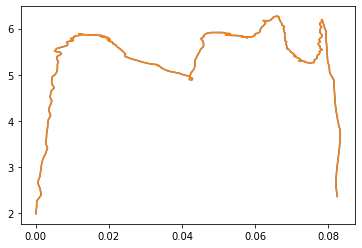

In [120]:
plt.plot(X,y1)
plt.plot(X,y_pr)
plt.show()